# Map AMP phase 1 onto phase 2 fine-grained references

Joyce Kang & Fan Zhang

2021-10-26

In this notebook, we will map the AMP Phase 1 scRNA-seq data onto the AMP Phase 2 cell-type-specific references. Goal is to associate the Phase 1 clusters to the Phase 2 clusters.

In [1]:
suppressPackageStartupMessages({
    library(symphony)
    library(pheatmap)
    library(ggrastr)
    library(tidyverse)
    library(ggthemes)
    library(RColorBrewer)
    library(ggrepel)
    library(uwot)
})

meta_colors <- list(
    "cell_type" = c(
        "B cell/plasma cell" = "#FDBF6F",
        "B cell" = "#FDBF6F",
        "DC" = "#CAB2D6",
        "Fibroblast" = "#08519C",
        "Stromal cell" = "#08519C",
        "Endothelial cell" = "#A6CEE3",
        "Macrophage" = "#6A3D9A",
        "Monocyte" = "#6A3D9A",
        "Myeloid cell" = "#6A3D9A",
        "T cell" = "#B2DF8A",
        "NK" = "#33A02C"
    )
)

#' Basic function to plot cells, colored and faceted by metadata variables
#' 
#' @param metadata metadata, with UMAP labels in UMAP1 and UMAP2 slots
#' @param title Plot title
#' @param color.by metadata column name for phenotype labels
#' @param facet.by metadata column name for faceting
#' @param color.mapping custom color mapping
#' @param show.legend Show cell type legend
plotBasic = function(umap_labels,                # metadata, with UMAP labels in UMAP1 and UMAP2 slots
                        title = 'Query',         # Plot title
                        color.by = 'cell_type',  # metadata column name for coloring
                        facet.by = NULL,         # (optional) metadata column name for faceting
                        color.mapping = NULL,    # custom color mapping
                        legend.position = 'right' , size = 0.5) {  # Show cell type legend
    
    p = umap_labels %>%
            dplyr::sample_frac(1L) %>% # permute rows randomly
            ggplot(aes(x = UMAP1, y = UMAP2)) + 
            geom_point_rast(aes(col = get(color.by)), size = size, stroke = 0.2, shape = 16)
        if (!is.null(color.mapping)) { p = p + scale_color_manual(values = color.mapping) }
    
    # Default formatting
    p = p + theme_bw() +
            labs(title = title, color = color.by) + 
            theme(plot.title = element_text(hjust = 0.5)) +
            theme(legend.position=legend.position) +
            theme(legend.text = element_text(size=8), legend.title=element_text(size=12)) + 
            guides(colour = guide_legend(override.aes = list(size = 4))) + guides(alpha = 'none')

    if(!is.null(facet.by)) {
        p = p + facet_wrap(~get(facet.by)) +
                theme(strip.text.x = element_text(size = 12)) }    
    return(p)
}

## Read in Symphony References (AMP Phase 2)

References built for this study.

In [2]:
## Names of the reference objects
ref_dir = './AMP2_references' # directory with Symphony references
all_ref_name = 'all_cells_reference_2021-07-13.rds'
B_ref_name = 'Bcell_reference_2021-09-10.rds'
T_ref_name = 'T_reference_2020-11-25.rds'
Fib_ref_name = 'fibroblast_reference_2021-09-10.rds'
Myeloid_ref_name = 'myeloid_reference_2021-04-29.rds'

## Read in all cell types reference
all_ref = readRDS(file.path(ref_dir, all_ref_name))
B_ref = readRDS(file.path(ref_dir, B_ref_name))
T_ref = readRDS(file.path(ref_dir, T_ref_name))
Fib_ref = readRDS(file.path(ref_dir, Fib_ref_name))
Myeloid_ref = readRDS(file.path(ref_dir, Myeloid_ref_name))

## Set the right paths for umap model in the Symphony object slot
all_ref$save_uwot_path = file.path(ref_dir, 'all_cells_uwot_model_2021-05-20')
B_ref$save_uwot_path = file.path(ref_dir, 'Bcell_uwot_model_2021-05-03.rds')
T_ref$save_uwot_path = file.path(ref_dir, 'T_uwot_model_2020-11-25.rds')
Fib_ref$save_uwot_path = file.path(ref_dir, 'fibroblast_uwot_model_2021-04-29')
Myeloid_ref$save_uwot_path = file.path(ref_dir, 'myeloid_uwot_model_2021-04-29')

A note: When publishing the uwot models, we should probably standardize the file extension (no .rds at the end), "T" to "Tcell"

In [3]:
## Write phase 2 variable gene names to a file in order to determine which
## Gencode version was used for gene quantification (see below)
write.csv(all_ref$vargenes$symbol, 'phase2_genenames.csv', row.names = FALSE)

## Read in Query data (AMP Phase 1)

scRNA-seq data from Zhang et al. (2019): Defining inflammatory cell states in rheumatoid arthritis joint synovial tissues by integrating single-cell transcriptomics and mass cytometry
https://www.nature.com/articles/s41590-019-0378-1

In [4]:
data_path = "/data/srlab/fzhang/amp/data/amp_ra_phase1/celseq_synovium_log2_5265cells_paper.rds"
metadata_path = "/data/srlab/fzhang/amp/data/amp_ra_phase1/celseq_synovium_meta_5265cells_paper.rds"

query_exp = readRDS(data_path)
query_metadata = readRDS(metadata_path)
colnames(query_metadata)[2] = "cell"
query_metadata = query_metadata[, c("cell", "sample", "cell_type", "disease", "plate", "cluster", "Mahalanobis_20")]
dim(query_exp)
dim(query_metadata)
query_metadata[1:4, ]

## Write gene names to a file
write.csv(rownames(query_exp), 'phase1_genenames.csv', row.names = FALSE)

[1] 32391  5265

[1] 5265    7

,cell,sample,cell_type,disease,plate,cluster,Mahalanobis_20
,<chr>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
4264,S006_L1Q1_A03,301-0159,T cell,OA,S006,SC-T1,OA
4265,S006_L1Q1_A05,301-0159,T cell,OA,S006,SC-T4,OA
4266,S006_L1Q1_A07,301-0159,T cell,OA,S006,SC-T1,OA
4267,S006_L1Q1_A09,301-0159,T cell,OA,S006,SC-T1,OA


## Determine which Gencode versions were used

In order to perform mapping, ideally the gene names should match up between reference and query. Different synonyms for the same gene can cause issues when mapping.

The functions below show how to quickly compare the gene names in a cell-by-gene
matrix to all GENCODE annotation GTF files for GRCh38. If none match well, 
the genes may have been mapped with GRCh37 (aka hg19) or with a RefSeq GTF file.

In [5]:
suppressPackageStartupMessages({
    library(purrr)
    library(data.table)
    library(furrr)
    library(glue)
    library(future)
    library(rtracklayer)
    library(dplyr)
})

First, let's download all the GTF files to examine. The URLs have mostly the 
same format: 

In [2]:
urls <- c(
  ## GRCh38
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{22:38}/gencode.v{22:38}.primary_assembly.annotation.gtf.gz'),
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{20:21}/gencode.v{20:21}.chr_patch_hapl_scaff.annotation.gtf.gz'),
  
  ## GRCh37
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{16:19}/gencode.v{16:19}.chr_patch_hapl_scaff.annotation.gtf.gz'),
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{4}/gencode_v{4}.annotation.GRCh37.gtf.gz'),
  glue('http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{5:15}/gencode.v{5:15}.annotation.gtf.gz'),
  'http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_3d/gencode.v3d.gtf.gz'
)

Because we will write these into the raw data directory with restricted write 
access, we'll need to wget with sudo, so execute these commands in the terminal:

In [ ]:
cmds <- as.character(glue('wget -P GENCODE  {urls}'))
map(cmds, system)

Next, let's read in the gtfs and extract gene names. 

In [ ]:
datadir <- 'GENCODE/'
fnames <- list.files(datadir, pattern='gencode.v\\d+.*gtf.gz')

## This step takes a while! Loads ~15GB of data 
plan(multicore)
gtfs <- file.path(datadir, fnames) %>% future_map(rtracklayer::import)
names(gtfs) <- gsub('(gencode.v\\d+).*', '\\1', fnames)

## gene symbols
gtf_genes <- gtfs %>% map(data.frame) %>% map('gene_name') %>% map(unique)

## ensembl IDs
gtf_ids <- gtfs %>% map(data.frame) %>% map('gene_id') %>% map(unique)

For future use, let's cache the gene names for each GTF, so we don't have to 
parse through the full GTF files again. 

In [ ]:
saveRDS(gtf_genes, 'GENCODE/gtf_genes.rds')
saveRDS(gtf_ids, 'GENCODE/gtf_ids.rds')

Read in previously cached files (same code as above to generate these files, but were generated from another study)

In [6]:
gtf_genes = readRDS('/data/srlab2/jkang/referencemapping/data/GENCODE/gtf_genes.rds')
gtf_ids = readRDS('/data/srlab2/jkang/referencemapping/data/GENCODE/gtf_ids.rds')

Now that we know which genes are accounted for in each GENCODE version, let's 
compare our gene names. In this example, gencode v19 has the only GTF that 
contains all the genes from our matrix, so it is clearly our winner. 

In [7]:
phase1_genes = read.csv('phase1_genenames.csv')
phase2_genes = read.csv('phase2_genenames.csv')

message('Number of phase 1 genes not covered by the GTF:')
map_dbl(gtf_genes, function(g) length(setdiff(phase1_genes$x, g))) %>% sort() %>% head()

message('Number of phase 2 genes not covered by the GTF:')
map_dbl(gtf_genes, function(g) length(setdiff(phase2_genes$x, g))) %>% sort() %>% head()

Number of phase 1 genes not covered by the GTF:



gencode.v19 gencode.v18 gencode.v20 gencode.v21 gencode.v22 gencode.v23 
          0         664        1323        1582        1857        1952

Number of phase 2 genes not covered by the GTF:



gencode.v29 gencode.v30 gencode.v31 gencode.v32 gencode.v27 gencode.v33 
         27          56          84          92          93         151

Looks like phase1 uses GENCODE version 19, whereas phase2 best matches version 29.

In [8]:
## Load the appropriate GTF files
phase1_gtf = rtracklayer::import('/data/srlab2/jkang/referencemapping/data/GENCODE/gencode.v19.chr_patch_hapl_scaff.annotation.gtf.gz')
phase2_gtf = rtracklayer::import('/data/srlab2/jkang/referencemapping/data/GENCODE/gencode.v29.primary_assembly.annotation.gtf.gz')

phase1_gtf %>% head(2)

GRanges object with 2 ranges and 20 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 11869-14412      + |   HAVANA gene              NA      <NA>
  [2]     chr1 11869-14409      + |   HAVANA transcript        NA      <NA>
                gene_id     transcript_id   gene_type gene_status   gene_name
            <character>       <character> <character> <character> <character>
  [1] ENSG00000223972.4 ENSG00000223972.4  pseudogene       KNOWN     DDX11L1
  [2] ENSG00000223972.4 ENST00000456328.2  pseudogene       KNOWN     DDX11L1
           transcript_type transcript_status transcript_name       level
               <character>       <character>     <character> <character>
  [1]           pseudogene             KNOWN         DDX11L1           2
  [2] processed_transcript             KNOWN     DDX11L1-002           2
               havana_gene         tag

Format the mapping table

In [9]:
# Remove everything after period '.' character in gtf files
phase1_gtf$gene_id = gsub("\\..*", "", phase1_gtf$gene_id)
phase2_gtf$gene_id = gsub("\\..*", "", phase2_gtf$gene_id)

In [10]:
# Remove duplicates
phase1_gtf_mapping = unique(mcols(phase1_gtf)[, c('gene_id', 'gene_name')]) %>% as.data.frame()
phase2_gtf_mapping = unique(mcols(phase2_gtf)[, c('gene_id', 'gene_name')]) %>% as.data.frame()

In [11]:
colnames(phase1_gtf_mapping)[2] = 'gene_name_phase1'
colnames(phase2_gtf_mapping)[2] = 'gene_name_phase2'
phase1_gtf_mapping %>% head(4)
phase2_gtf_mapping %>% head(4)
nrow(phase1_gtf_mapping)
nrow(phase2_gtf_mapping)

,gene_id,gene_name_phase1
,<chr>,<chr>
1,ENSG00000223972,DDX11L1
2,ENSG00000227232,WASH7P
3,ENSG00000243485,MIR1302-11
4,ENSG00000237613,FAM138A


,gene_id,gene_name_phase2
,<chr>,<chr>
1,ENSG00000223972,DDX11L1
2,ENSG00000227232,WASH7P
3,ENSG00000278267,MIR6859-1
4,ENSG00000243485,MIR1302-2HG


[1] 63568

[1] 58735

Merge on Ensembl gene_id (which should remain stable between Gencode versions)

In [12]:
combined_mapping = merge(phase1_gtf_mapping, phase2_gtf_mapping, by = 'gene_id')
combined_mapping %>% head(4)
nrow(combined_mapping)

,gene_id,gene_name_phase1,gene_name_phase2
,<chr>,<chr>,<chr>
1,ENSG00000000003,TSPAN6,TSPAN6
2,ENSG00000000005,TNMD,TNMD
3,ENSG00000000419,DPM1,DPM1
4,ENSG00000000457,SCYL3,SCYL3


[1] 52526

In [13]:
# Example of a gene named differently between Phase 1 and Phase 2
'CXCL8' %in% combined_mapping$gene_name_phase2
combined_mapping %>% subset(gene_name_phase2 == 'CXCL8')

[1] TRUE

,gene_id,gene_name_phase1,gene_name_phase2
,<chr>,<chr>,<chr>
12592,ENSG00000169429,IL8,CXCL8


Remove genes that aren't in the phase 1 expression matrix

In [14]:
length(which(phase1_genes$x %in% combined_mapping$gene_name_phase1))
length(phase1_genes$x)
combined_mapping = combined_mapping[which(combined_mapping$gene_name_phase1 %in% phase1_genes$x),]
nrow(combined_mapping)

[1] 30728

[1] 32391

[1] 30751

Looks like there may be some duplicated phase 1 genes - handle duplicated gene names.

In [15]:
# Remove duplicate rows based on [gene_name_phase1 and gene_name_phase2]
combined_mapping = combined_mapping %>% distinct(gene_name_phase1, gene_name_phase2, .keep_all= TRUE)

In [16]:
## Print rows with duplicated phase 1 or phase 2 gene names
combined_mapping[duplicated(combined_mapping$gene_name_phase1, fromLast = TRUE) | 
                 duplicated(combined_mapping$gene_name_phase1), ] %>% head(4)
combined_mapping[duplicated(combined_mapping$gene_name_phase2, fromLast = TRUE) | 
                 duplicated(combined_mapping$gene_name_phase2), ] %>% head(4)

,gene_id,gene_name_phase1,gene_name_phase2
,<chr>,<chr>,<chr>
14714,ENSG00000184185,KCNJ12,KCNJ12
15949,ENSG00000196696,PDXDC2P,PDXDC2P-NPIPB14P
17291,ENSG00000204174,NPY4R,NPY4R
18269,ENSG00000212135,SNORD67,SNORD67


,gene_id,gene_name_phase1,gene_name_phase2
,<chr>,<chr>,<chr>
4191,ENSG00000114395,CYB561D2,CYB561D2
8112,ENSG00000143248,RGS5,RGS5
11268,ENSG00000165655,ZNF503,ZNF503
14468,ENSG00000182957,SPATA13,SPATA13


How many gene names are actually different between phase 1 and phase 2 in our mapping file (# rescued)?

In [17]:
combined_mapping_for_fixing = combined_mapping[which(combined_mapping$gene_name_phase1 != 
                                                     combined_mapping$gene_name_phase2), ]
nrow(combined_mapping_for_fixing)
combined_mapping_for_fixing %>% head(4)

[1] 9667

,gene_id,gene_name_phase1,gene_name_phase2
,<chr>,<chr>,<chr>
56,ENSG00000004766,CCDC132,VPS50
76,ENSG00000005059,CCDC109B,MCUB
85,ENSG00000005189,AC004381.6,REXO5
93,ENSG00000005379,BZRAP1,TSPOAP1


In [18]:
combined_mapping_for_fixing[duplicated(combined_mapping_for_fixing$gene_name_phase1), ]

,gene_id,gene_name_phase1,gene_name_phase2
,<chr>,<chr>,<chr>
28465,ENSG00000264343,NOTCH2NL,NOTCH2NLA
29810,ENSG00000270231,NBPF10,NBPF8
29878,ENSG00000270882,HIST1H4A,HIST2H4A
29928,ENSG00000271254,NBPF10,AC240274.1


There are now only 4 rows with duplicated phase1 names - remove the duplicates.

In [19]:
combined_mapping_for_fixing = combined_mapping_for_fixing %>% distinct(gene_name_phase1, .keep_all= TRUE)
nrow(combined_mapping_for_fixing)

[1] 9663

In [20]:
saveRDS(combined_mapping_for_fixing, 'combined_mapping_for_fixing.rds')

## Sync gene names 
Rename the mismatching phase 1 gene names to phase 2 gene names using shared Ensembl ID.

In [21]:
new_phase1_genes = phase1_genes$x
count = 0
for (i in 1:length(phase1_genes$x)) {
    gene = phase1_genes$x[i]
    if (gene %in% combined_mapping_for_fixing$gene_name_phase1) {
        idx_in_mapping = which(combined_mapping_for_fixing$gene_name_phase1 == gene)
        phase2name = combined_mapping_for_fixing[idx_in_mapping, 'gene_name_phase2']
        new_phase1_genes[i] = phase2name
        count = count + 1
    }
}
print(paste(count, 'genes names changed.'))

## Check whether CXCL8 is now present
'CXCL8' %in% new_phase1_genes

## Write new (fixed) phase 1 gene names
write.csv(new_phase1_genes, 'new_phase1_genes.csv', row.names = FALSE)

[1] "9663 genes names changed."


[1] TRUE

"Translate" Phase 1 gene names into Phase 2 gene names

In [22]:
new_phase1_genes = read.csv('new_phase1_genes.csv')$x
rownames(query_exp) = new_phase1_genes

# Symphony mapping

## Broad cell types
Map query cells to all cell types reference

In [23]:
query = mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 all_ref,               # Symphony reference object
                 vars = c('sample'),    # also integrate over query batches
                 do_normalize = FALSE,  # perform log(CP10k) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 5360 out of 5751 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [24]:
# Predict query cell types using k-NN
set.seed(1)
query = knnPredict(query, all_ref, all_ref$meta_data$cell_type, k = 5, confidence = TRUE)
query$meta_data %>% head(4)

,cell,sample,cell_type,disease,plate,cluster,Mahalanobis_20,cell_type_pred_knn,cell_type_pred_knn_prob
,<chr>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>,<fct>,<dbl>
4264,S006_L1Q1_A03,301-0159,T cell,OA,S006,SC-T1,OA,T cell,0.8
4265,S006_L1Q1_A05,301-0159,T cell,OA,S006,SC-T4,OA,T cell,0.8
4266,S006_L1Q1_A07,301-0159,T cell,OA,S006,SC-T1,OA,T cell,1.0
4267,S006_L1Q1_A09,301-0159,T cell,OA,S006,SC-T1,OA,T cell,1.0


Visualize mapping

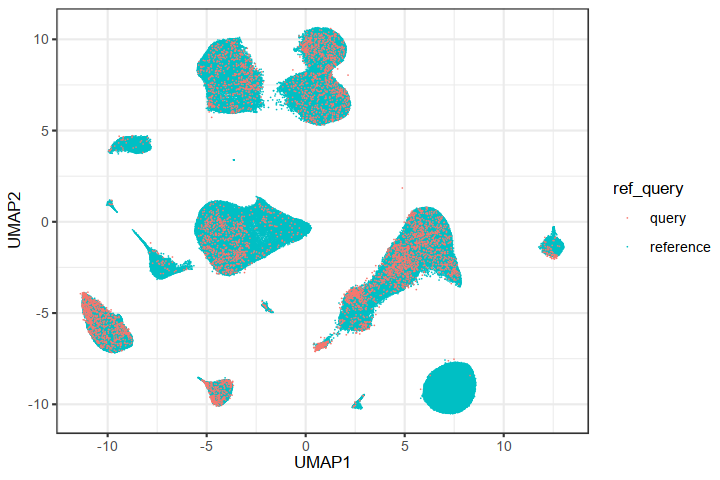

In [25]:
# Sync the column names for both data frames
all_ref$meta_data$cell_type_pred_knn = NA
all_ref$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query$meta_data[, c("cell", "sample", "cell_type", "cell_type_pred_knn", "ref_query")], 
                           all_ref$meta_data[, c("cell", "sample", "cell_type", "cell_type_pred_knn", "ref_query")])
umap_combined = rbind(query$umap, all_ref$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
  geom_point(data = umap_combined_labels[rev(order(umap_combined_labels$ref_query)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "ref_query"),
    size = 0.2, stroke = 0.0001, shape = 21) +
  theme_bw(base_size = 10) +
  theme(plot.title = element_text(color="black", size=10))

Plot side by side

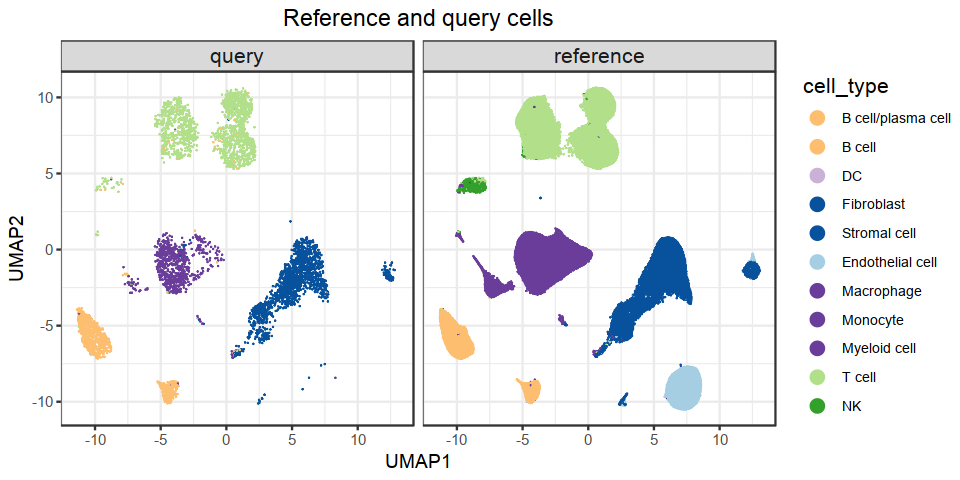

In [26]:
options(repr.plot.height = 4, repr.plot.width = 8)
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cell_type', facet.by = 'ref_query', color.mapping = meta_colors$cell_type)

## B cells
Map query B cells to B cell reference

In [27]:
## Subset out the query B cells
idx_queryB = which(query_metadata$cell_type == 'B cell')
exp_queryB = query_exp[, idx_queryB]
meta_queryB = query_metadata[idx_queryB, ]
meta_queryB %>% head(4)

,cell,sample,cell_type,disease,plate,cluster,Mahalanobis_20
,<chr>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
4552,S012_L1Q1_C01,301-0161,B cell,OA,S012,SC-B4,OA
4553,S012_L1Q1_C03,301-0161,B cell,OA,S012,SC-B4,OA
4554,S012_L1Q1_C05,301-0161,B cell,OA,S012,SC-B4,OA
4555,S012_L1Q1_C07,301-0161,B cell,OA,S012,SC-B2,OA


In [28]:
table(meta_queryB$sample)


300-0122 300-0153 300-0211 300-0213 300-0481 300-0482 300-0483 300-0485 
      71        0        0        0        0       87      100       23 
300-0486 300-0487 300-0511 300-0528 300-0546 300-2590 301-0121 301-0122 
      86       98      127       63       95      115        0       31 
301-0132 301-0151 301-0153 301-0155 301-0159 301-0161 301-0163 301-0244 
     114        0        0        0        0       36        0        0 
301-0250     none 
      96        0 

Since there are very few cells per query sample, we will not correct for query batch during mapping.

In [29]:
queryB = mapQuery(exp_queryB,           # query gene expression (genes x cells)
                 meta_queryB,           # query metadata (cells x attributes)
                 B_ref,                 # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 6459 out of 6647 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [30]:
# Predict query cell types using k-NN
set.seed(1)
options(repr.plot.height = 4, repr.plot.width = 8)
queryB = knnPredict(queryB, B_ref, B_ref$meta_data$cluster_name, 
                   k = 5, save_as = 'B_pred_knn_5', confidence = TRUE)

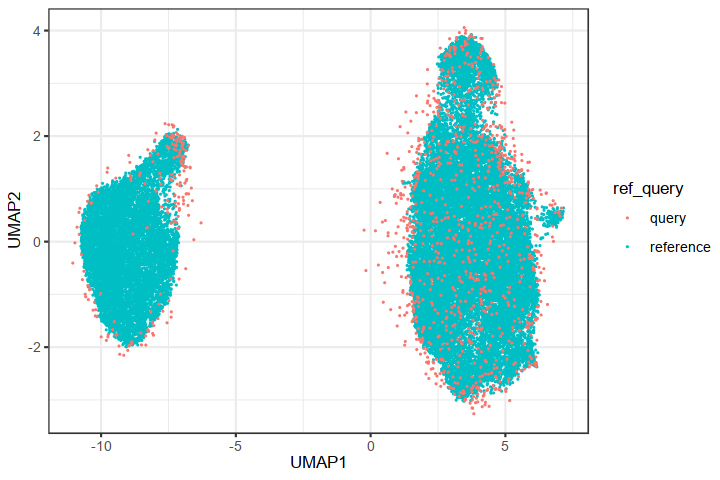

In [31]:
# Visualize of mapping
# Sync the column names for both data frames
B_ref$meta_data$B_pred_knn_5 = NA
B_ref$meta_data$ref_query = 'reference'
queryB$meta_data$ref_query = 'query'
B_ref$meta_data$cluster = B_ref$meta_data$cluster_name

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(queryB$meta_data[, c("cell", "sample", "cluster", "B_pred_knn_5", "ref_query")], 
                           B_ref$meta_data[, c("cell", "sample", "cluster", "B_pred_knn_5", "ref_query")])
umap_combined = rbind(queryB$umap, B_ref$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# Plot UMAP visualization of all cells
# plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'ref_query')
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
  geom_point(
    data = umap_combined_labels[rev(order(umap_combined_labels$ref_query)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "ref_query"),
    size = 0.6, stroke = 0.0001, shape = 21) +
  theme_bw(base_size = 10) +
  theme(plot.title = element_text(color="black", size=10))

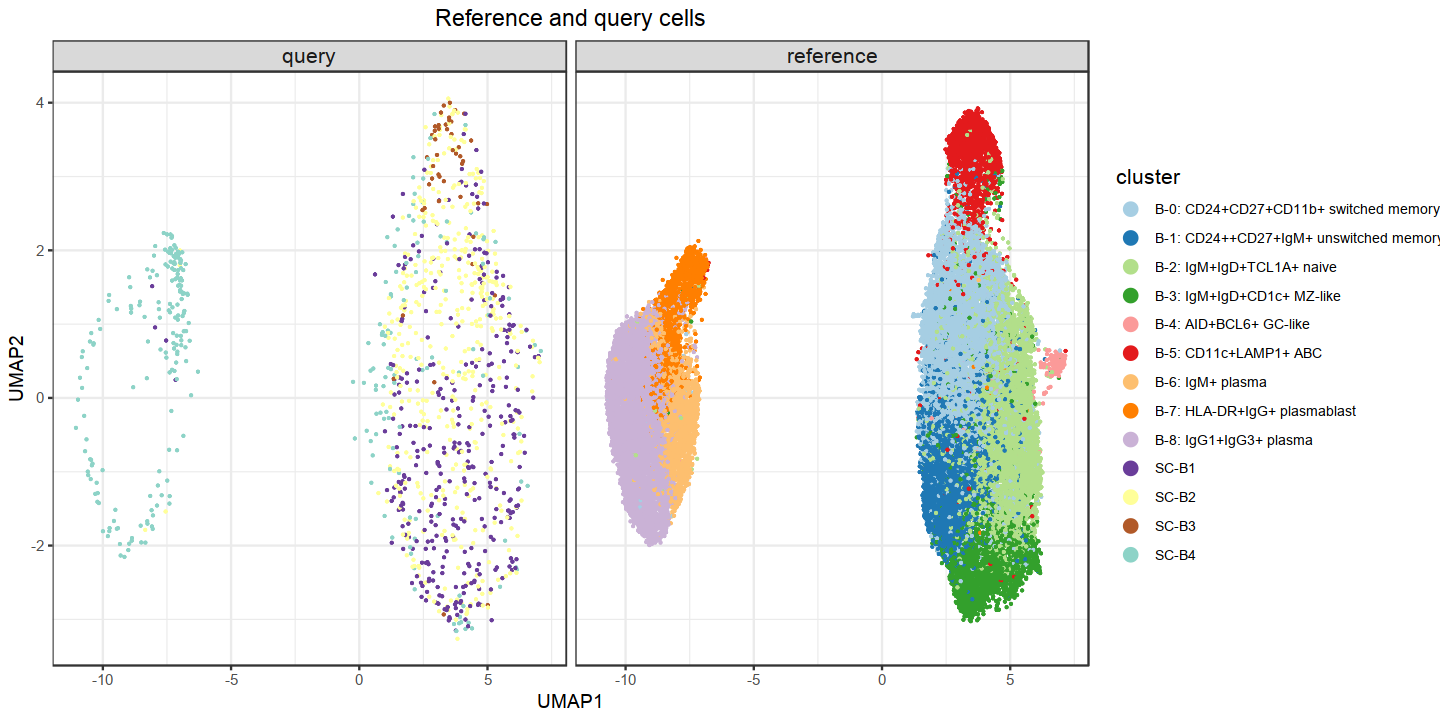

In [32]:
options(repr.plot.height = 6, repr.plot.width = 12)
colors = c( RColorBrewer::brewer.pal(12,'Paired'), RColorBrewer::brewer.pal(12,'Set3'))
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cluster', facet.by = 'ref_query', size = 1) + scale_color_manual(values = colors)

In [33]:
table(queryB$meta_data$B_pred_knn_5, queryB$meta_data$cluster)

                                        
                                         SC-B1 SC-B2 SC-B3 SC-B4
  B-0: CD24+CD27+CD11b+ switched memory     70   176     4    53
  B-2: IgM+IgD+TCL1A+ naive                106    96     1    19
  B-8: IgG1+IgG3+ plasma                     2     7     0    77
  B-1: CD24++CD27+IgM+ unswitched memory    78    46     1    12
  B-3: IgM+IgD+CD1c+ MZ-like                60    51     3    15
  B-5: CD11c+LAMP1+ ABC                     18    49    38    10
  B-6: IgM+ plasma                           4     0     0    18
  B-7: HLA-DR+IgG+ plasmablast              12     8     0    86
  B-4: AID+BCL6+ GC-like                     5     7     1     9

In [34]:
saveRDS(queryB, 'Query_Objects/query_B.rds')

### Log(OR)
Plot the log odds-ratio

In [35]:
t = table(queryB$meta_data$B_pred_knn_5, queryB$meta_data$cluster)
tpseudo = t %>% Matrix() + 0.5 # Add pseudocount
or = tpseudo # initialize results (same dimensions as t)
for (i in 1:ncol(tpseudo)) { # for each phase 1 cluster
    for (j in 1:nrow(t)) {   # for each phase 2 cluster 
        a = tpseudo[j, i]
        b = sum(tpseudo[j, -i])
        c = sum(tpseudo[-j, i])
        d = sum(tpseudo[-j, -i])
        
        or[j, i] = (a/b) / (c/d)
    }
}
round(log(or), 3)

9 x 4 Matrix of class "dgeMatrix"
                                        
                                          SC-B1  SC-B2  SC-B3  SC-B4
  B-0: CD24+CD27+CD11b+ switched memory  -0.530  1.101 -1.379 -0.664
  B-2: IgM+IgD+TCL1A+ naive               0.895  0.246 -2.146 -1.519
  B-8: IgG1+IgG3+ plasma                 -2.838 -2.000 -2.188  3.319
  B-1: CD24++CD27+IgM+ unswitched memory  1.229 -0.240 -1.573 -1.395
  B-3: IgM+IgD+CD1c+ MZ-like              0.740  0.047 -0.600 -1.063
  B-5: CD11c+LAMP1+ ABC                  -0.950  0.185  3.585 -1.377
  B-6: IgM+ plasma                       -0.678 -3.406 -0.813  2.307
  B-7: HLA-DR+IgG+ plasmablast           -1.325 -2.114 -2.414  2.740
  B-4: AID+BCL6+ GC-like                 -0.420 -0.319  0.349  0.629

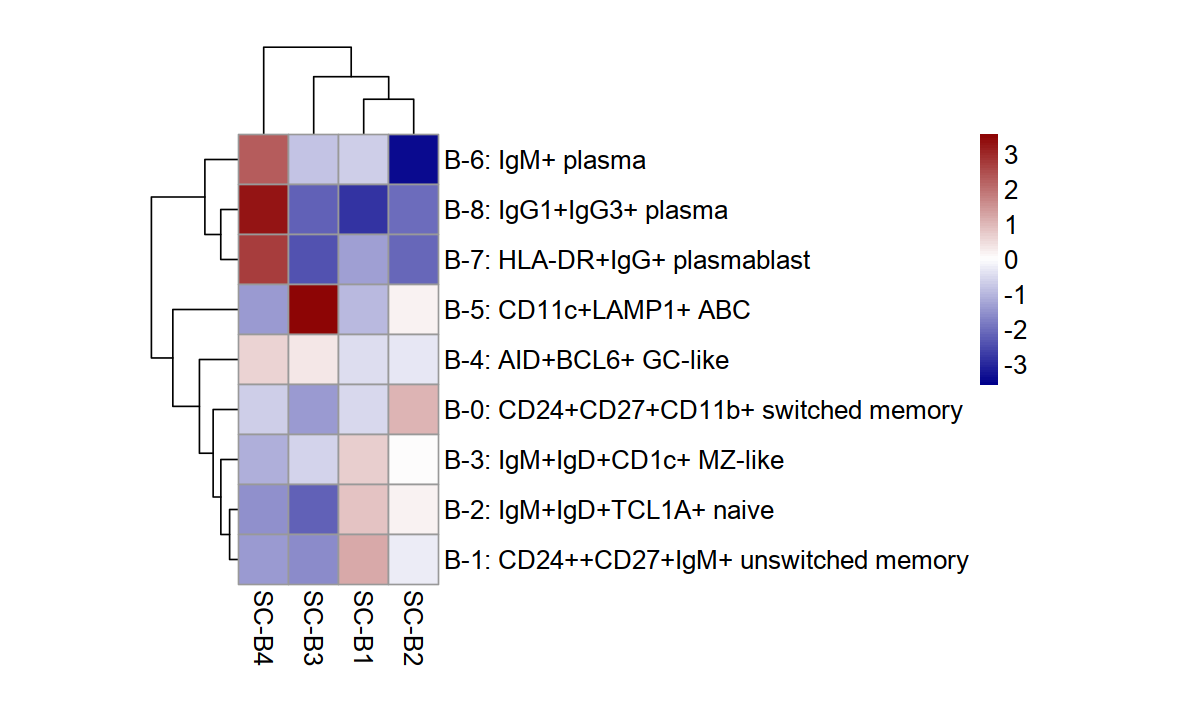

In [36]:
options(repr.plot.height = 6, repr.plot.width = 10)
range <- max(log(or))

pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
         fontsize = 15, cellheight = 30, cellwidth = 30)

# Save to figures
pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
         fontsize = 15, cellheight = 30, cellwidth = 30, 
         filename = 'figures/B_heatmap.pdf')

## T cells

Map query T cells to T cell reference

In [37]:
## Subset out the query T cells
idx_queryT = which(query_metadata$cell_type == 'T cell')
exp_queryT = query_exp[, idx_queryT]
meta_queryT = query_metadata[idx_queryT, ]

## Map the query cells to the fine-grained reference
queryT = mapQuery(exp_queryT,           # query gene expression (genes x cells)
                 meta_queryT,           # query metadata (cells x attributes)
                 T_ref,                 # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 4870 out of 5179 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [38]:
which(is.na(T_ref$meta_data$cluster_name))

[1]  6746  7289 28426 41424 59538 78356 83635 93951

Since some of the reference cells are labeled NA, we will remove them prior to prediction.

In [39]:
# Remove NA cells from reference
idx_na = which(is.na(T_ref$meta_data$cluster_name))
T_ref$meta_data = T_ref$meta_data[-idx_na, ]
T_ref$Z_corr = T_ref$Z_corr[,-idx_na]
T_ref$Z_orig = T_ref$Z_orig[,-idx_na] # not essential
T_ref$R = T_ref$R[,-idx_na]
T_ref$umap$embedding = T_ref$umap$embedding[-idx_na,]

In [40]:
# Predict query cell types using k-NN
options(repr.plot.height = 4, repr.plot.width = 6)
set.seed(1)
queryT = knnPredict(queryT, T_ref, T_ref$meta_data$cluster_name, 
                   k = 5, save_as = 'T_pred_knn_5', confidence = TRUE)

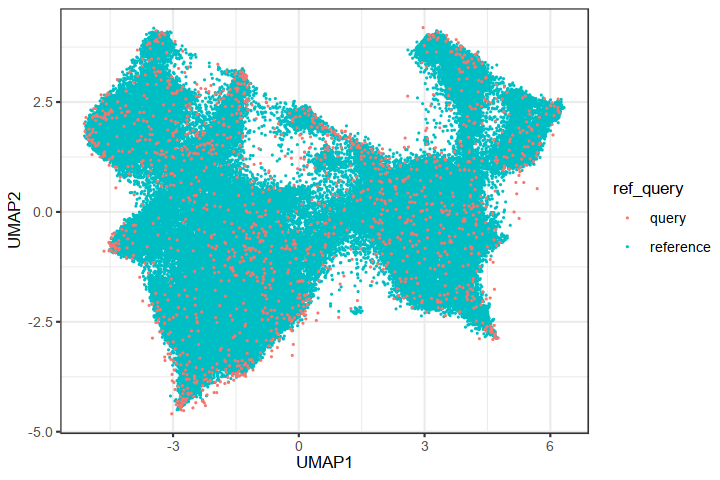

In [41]:
# Visualize of mapping
# Sync the column names for both data frames
T_ref$meta_data$T_pred_knn_5 = NA
T_ref$meta_data$ref_query = 'reference'
queryT$meta_data$ref_query = 'query'
T_ref$meta_data$cluster = T_ref$meta_data$cluster_name

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(queryT$meta_data[, c("cell", "sample", "cluster", "T_pred_knn_5", "ref_query")], 
                           T_ref$meta_data[, c("cell", "sample", "cluster", "T_pred_knn_5", "ref_query")])
umap_combined = rbind(queryT$umap, T_ref$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# Plot UMAP visualization of all cells
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
  geom_point(data = umap_combined_labels[rev(order(umap_combined_labels$ref_query)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "ref_query"),
    size = 0.6, stroke = 0.0001, shape = 21) +
  theme_bw(base_size = 10) +
  theme(plot.title = element_text(color="black", size=10))

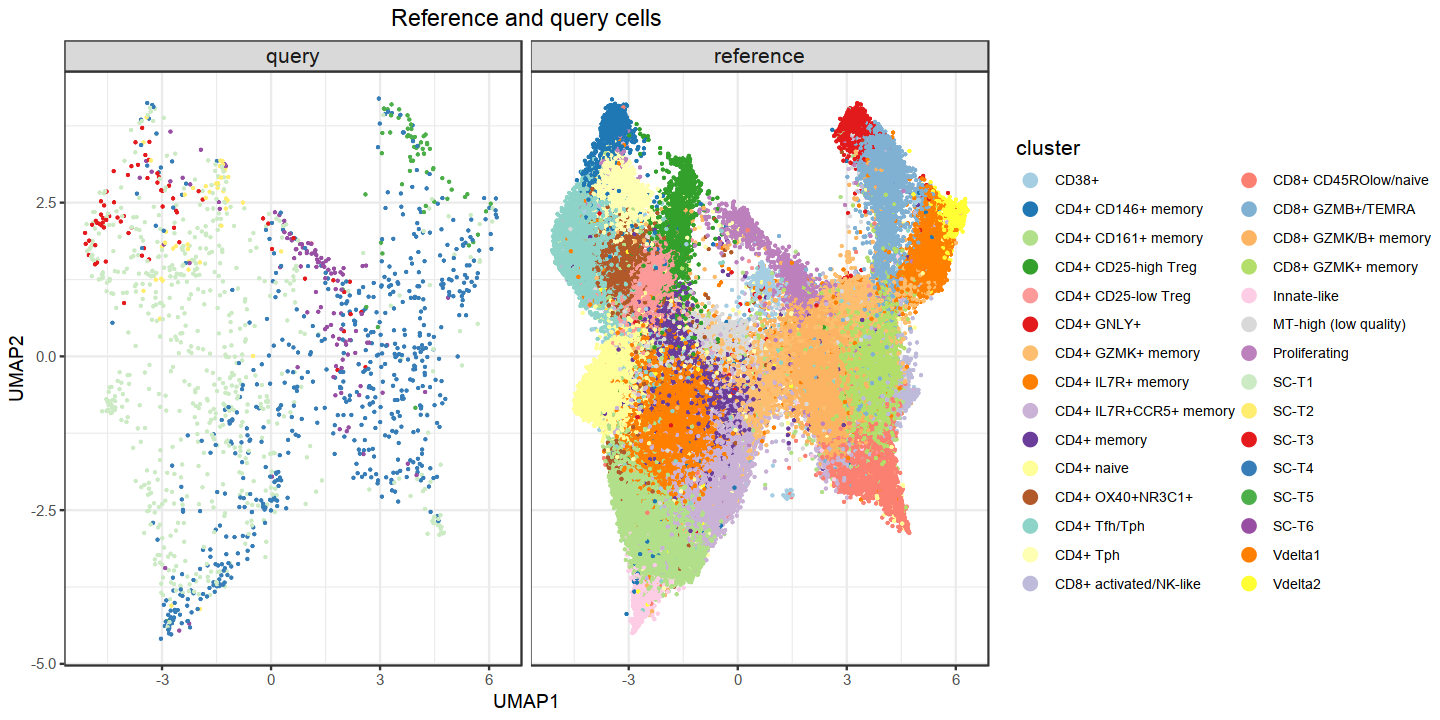

In [42]:
options(repr.plot.height = 6, repr.plot.width = 12)

colors = c(RColorBrewer::brewer.pal(12,'Paired'), 
           RColorBrewer::brewer.pal(12,'Set3'), 
           RColorBrewer::brewer.pal(9,'Set1'))
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cluster', facet.by = 'ref_query', size = 1) + scale_color_manual(values = colors)

In [43]:
table(queryT$meta_data$T_pred_knn_5, queryT$meta_data$cluster)

                        
                         SC-T1 SC-T2 SC-T3 SC-T4 SC-T5 SC-T6
  CD38+                     21     0     2     8     1     3
  CD4+ CD146+ memory        18     2     7    12     0     3
  CD4+ CD161+ memory        71     0     1    39     0     2
  CD4+ CD25-high Treg       44    28     2     3     0     6
  CD4+ CD25-low Treg        42     4     0     1     0     0
  CD4+ GNLY+                 1     0     0     6    13     0
  CD4+ GZMK+ memory         19     0     1    54     4     2
  CD4+ IL7R+ memory         91     0     0    25     0     2
  CD4+ IL7R+CCR5+ memory    29     1     0    57     0     1
  CD4+ memory               21     0     0     3     0     1
  CD4+ naive                48     0     0     1     0     0
  CD4+ OX40+NR3C1+          39     4     4     3     0     1
  CD4+ Tfh/Tph              74     3    27     6     0     0
  CD4+ Tph                  18     4    12    15     0     5
  CD8+ activated/NK-like     7     0     1     9     0     0

In [44]:
saveRDS(queryT, 'Query_Objects/query_T.rds')

### Log(OR)
Plot the log odds-ratio

In [45]:
t = table(queryT$meta_data$T_pred_knn_5, queryT$meta_data$cluster)

tpseudo = t %>% Matrix() + 0.5 # Add pseudocount
or = tpseudo # initialize results (same dimensions as t)
for (i in 1:ncol(tpseudo)) { # for each phase 1 cluster
    for (j in 1:nrow(t)) { # for each phase 2 cluster 
        a = tpseudo[j, i]
        b = sum(tpseudo[j, -i])
        c = sum(tpseudo[-j, i])
        d = sum(tpseudo[-j, -i])
        
        or[j, i] = (a/b) / (c/d)
    }
}
round(log(or), 3)

24 x 6 Matrix of class "dgeMatrix"
                        
                          SC-T1  SC-T2  SC-T3  SC-T4  SC-T5  SC-T6
  CD38+                   0.669 -1.088  0.273 -0.789 -0.183  0.212
  CD4+ CD146+ memory      0.030  0.427  1.381 -0.496 -1.499  0.023
  CD4+ CD161+ memory      0.932 -2.266 -1.476 -0.203 -2.502 -1.380
  CD4+ CD25-high Treg     0.485  3.150 -0.615 -2.770 -2.180 -0.009
  CD4+ CD25-low Treg      2.183  0.980 -1.703 -3.052 -1.608 -2.130
  CD4+ GNLY+             -2.295 -0.567 -0.896 -0.466  3.557 -1.323
  CD4+ GZMK+ memory      -0.831 -1.907 -1.113  1.184  0.163 -1.012
  CD4+ IL7R+ memory       1.641 -2.312 -2.642 -0.908 -2.547 -1.426
  CD4+ IL7R+CCR5+ memory -0.366 -0.877 -2.335  1.076 -2.240 -1.644
  CD4+ memory             1.612 -0.771 -1.100 -1.493 -1.006 -0.382
  CD4+ naive              3.091 -1.415 -1.744 -3.095 -1.649 -2.171
  CD4+ OX40+NR3C1+        1.438  0.893  0.545 -2.244 -1.689 -1.084
  CD4+ Tfh/Tph            1.130 -0.211  2.135 -2.428 -2.473 -2.996
  

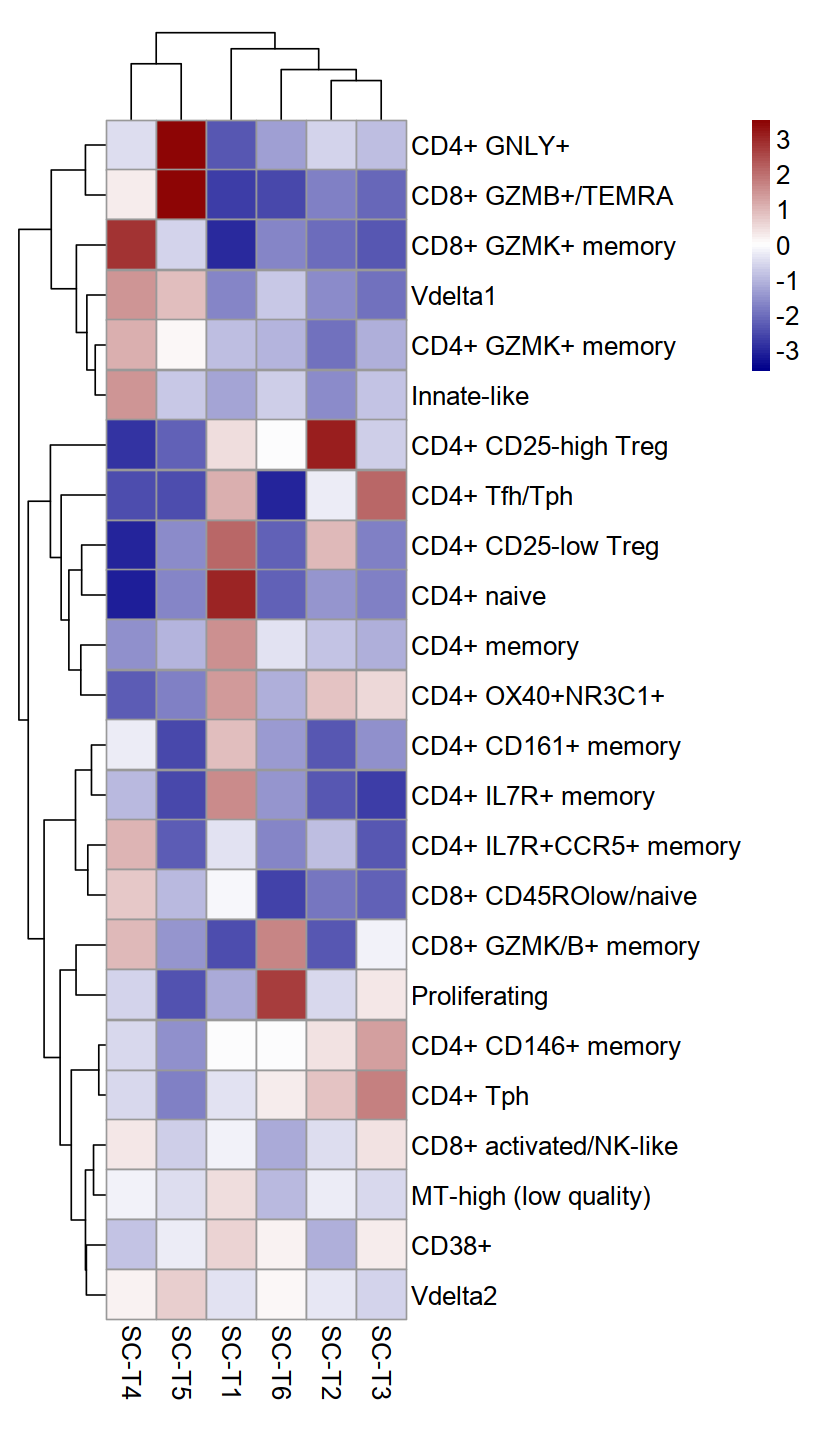

In [46]:
options(repr.plot.height = 12, repr.plot.width = 7)
range <- max(log(or))

pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
         fontsize = 15, cellheight = 30, cellwidth = 30)

# Save to figures
pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
         fontsize = 15, cellheight = 30, cellwidth = 30, filename = 'figures/T_heatmap.pdf')

## Fibroblasts
Map query fibroblasts to stromal cell reference

In [47]:
## Subset out the query fibroblasts
idx_queryF = which(query_metadata$cell_type == 'Fibroblast')
exp_queryF = query_exp[, idx_queryF]
meta_queryF = query_metadata[idx_queryF, ]

## Map the query cells to the fine-grained reference
queryF = mapQuery(exp_queryF,           # query gene expression (genes x cells)
                 meta_queryF,           # query metadata (cells x attributes)
                 Fib_ref,               # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 5630 out of 5811 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [48]:
# Predict query cell types using k-NN
options(repr.plot.height = 4, repr.plot.width = 6)
set.seed(1)
queryF = knnPredict(queryF, Fib_ref, Fib_ref$meta_data$cluster_name, 
                   k = 5, save_as = 'Fib_pred_knn_5', confidence = TRUE)

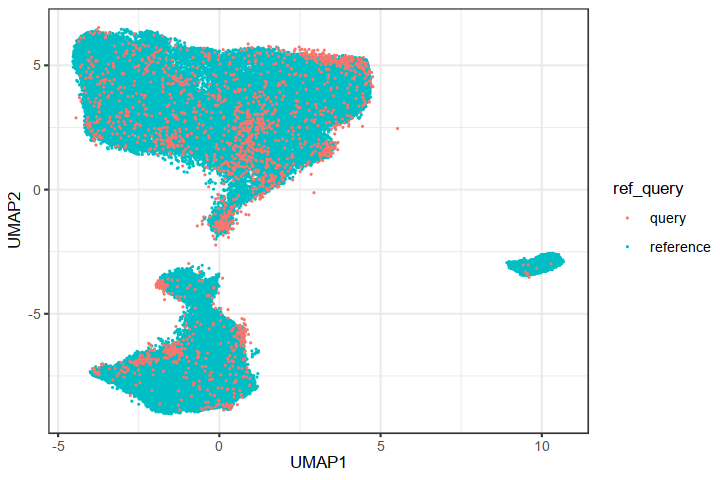

In [49]:
# Visualize of mapping
# Sync the column names for both data frames
Fib_ref$meta_data$Fib_pred_knn_5 = NA
Fib_ref$meta_data$ref_query = 'reference'
queryF$meta_data$ref_query = 'query'
Fib_ref$meta_data$cluster = Fib_ref$meta_data$cluster_name

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(queryF$meta_data[, c("cell", "sample", "cluster", "Fib_pred_knn_5", "ref_query")], 
                           Fib_ref$meta_data[, c("cell", "sample", "cluster", "Fib_pred_knn_5", "ref_query")])
umap_combined = rbind(queryF$umap, Fib_ref$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# Plot UMAP visualization of all cells
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
  geom_point(data = umap_combined_labels[rev(order(umap_combined_labels$ref_query)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "ref_query"),
    size = 0.6, stroke = 0.0001, shape = 21) +
  theme_bw(base_size = 10) +
  theme(plot.title = element_text(color="black", size=10))

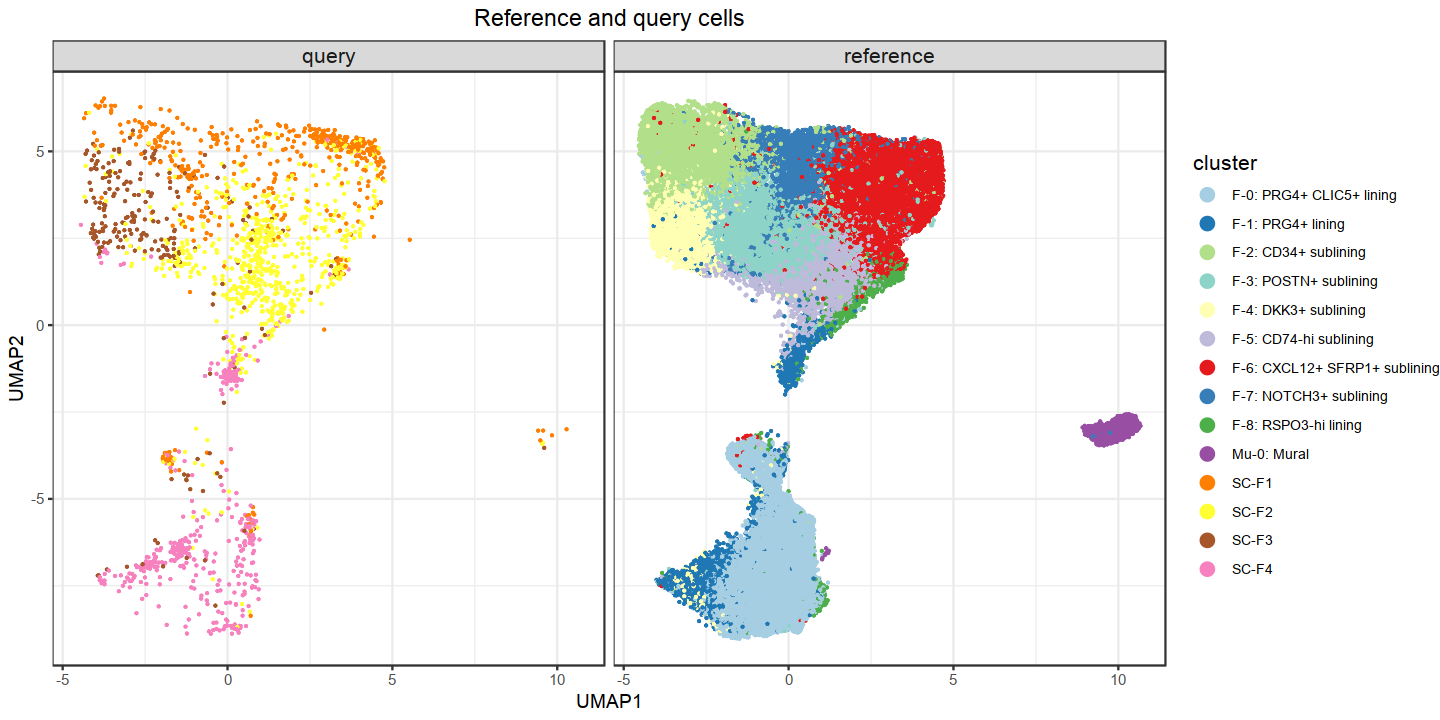

In [50]:
options(repr.plot.height = 6, repr.plot.width = 12)
colors = c(RColorBrewer::brewer.pal(3,'Paired'), 
           RColorBrewer::brewer.pal(3,'Set3'), 
           RColorBrewer::brewer.pal(9,'Set1'))
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cluster', facet.by = 'ref_query', size = 1) + scale_color_manual(values = colors)

In [51]:
table(queryF$meta_data$Fib_pred_knn_5, queryF$meta_data$cluster)

                               
                                SC-F1 SC-F2 SC-F3 SC-F4
  F-0: PRG4+ CLIC5+ lining         64    55    16   265
  F-1: PRG4+ lining                 0    25     5    99
  F-2: CD34+ sublining             68    18    56     0
  F-3: POSTN+ sublining            41    66    41     0
  F-4: DKK3+ sublining              4    25    86    34
  F-5: CD74-hi sublining            2   225     5     5
  F-6: CXCL12+ SFRP1+ sublining   136   149     5     1
  F-7: NOTCH3+ sublining           80   111     9     1
  F-8: RSPO3-hi lining              0    14     1     2
  Mu-0: Mural                      89    31     4     6

In [52]:
saveRDS(queryF, 'Query_Objects/query_F.rds')

### Log(OR)
Plot the log odds-ratio

In [53]:
t = table(queryF$meta_data$Fib_pred_knn_5, queryF$meta_data$cluster)
tpseudo = t %>% Matrix() + 0.5 # Add pseudocount
or = tpseudo # initialize results (same dimensions as t)
for (i in 1:ncol(tpseudo)) { # for each phase 1 cluster
    for (j in 1:nrow(t)) {   # for each phase 2 cluster 
        a = tpseudo[j, i]
        b = sum(tpseudo[j, -i])
        c = sum(tpseudo[-j, i])
        d = sum(tpseudo[-j, -i])
        
        or[j, i] = (a/b) / (c/d)
    }
}
round(log(or), 3)

10 x 4 Matrix of class "dgeMatrix"
                               
                                 SC-F1  SC-F2  SC-F3  SC-F4
  F-0: PRG4+ CLIC5+ lining      -0.761 -1.660 -1.401  2.816
  F-1: PRG4+ lining             -4.629 -1.027 -1.238  2.641
  F-2: CD34+ sublining           1.031 -1.551  1.731 -4.522
  F-3: POSTN+ sublining          0.079  0.247  1.112 -4.567
  F-4: DKK3+ sublining          -2.553 -1.220  2.663  0.026
  F-5: CD74-hi sublining        -3.699  3.631 -1.933 -2.670
  F-6: CXCL12+ SFRP1+ sublining  1.104  0.592 -2.181 -4.250
  F-7: NOTCH3+ sublining         0.701  0.735 -1.153 -3.806
  F-8: RSPO3-hi lining          -2.590  1.640 -0.515 -0.651
  Mu-0: Mural                    1.949 -0.754 -1.460 -1.795

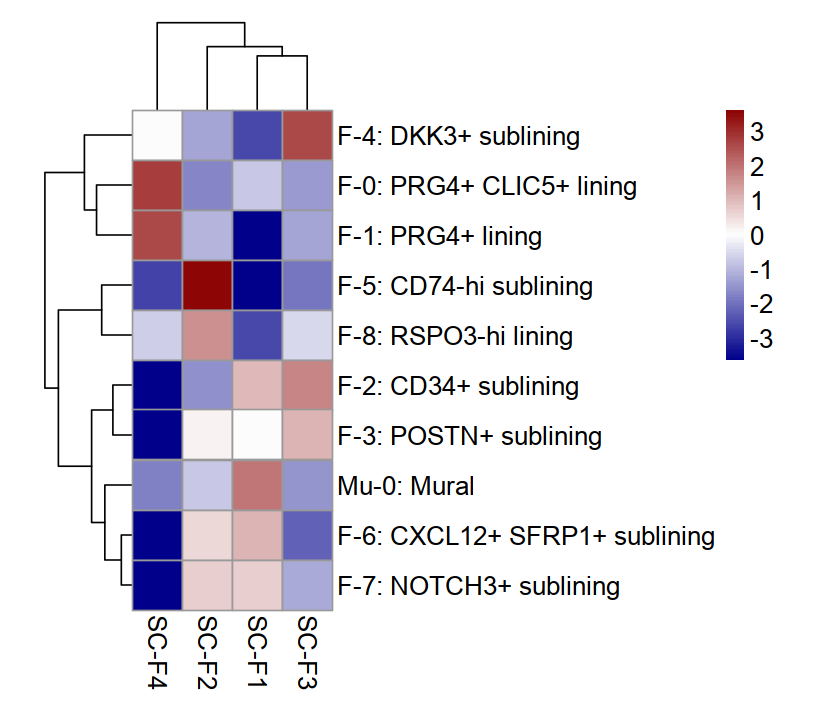

In [54]:
options(repr.plot.height = 6, repr.plot.width = 7)
range <- max(log(or))
pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
          fontsize = 15, cellheight = 30, cellwidth = 30)

# Save to figures
pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
          fontsize = 15, cellheight = 30, cellwidth = 30, filename = 'figures/F_heatmap.pdf')

## Myeloid

In [55]:
## Subset out the query monocytes
idx_queryM = which(query_metadata$cell_type == 'Monocyte')
exp_queryM = query_exp[, idx_queryM]
meta_queryM = query_metadata[idx_queryM, ]

## Map the query cells to the fine-grained reference
queryM = mapQuery(exp_queryM,           # query gene expression (genes x cells)
                 meta_queryM,           # query metadata (cells x attributes)
                 Myeloid_ref,           # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression

Found 3350 out of 3547 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [56]:
# Predict query cell types using k-NN
options(repr.plot.height = 4, repr.plot.width = 6)
set.seed(1)
queryM = knnPredict(queryM, Myeloid_ref, Myeloid_ref$meta_data$cluster_name, 
                   k = 5, save_as = 'M_pred_knn_5', confidence = TRUE)

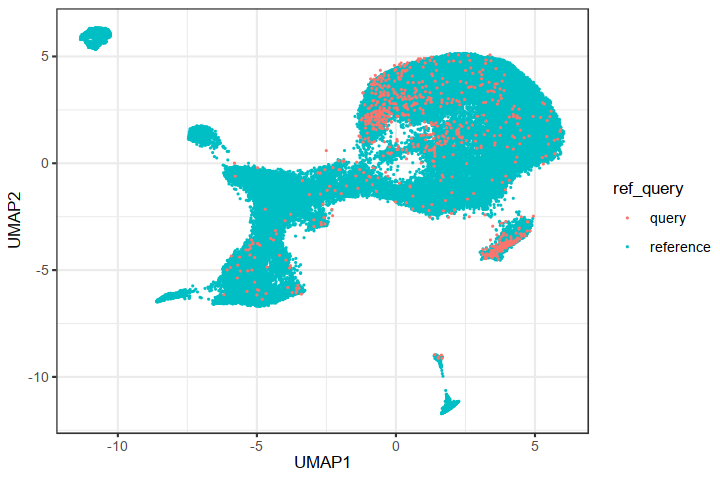

In [57]:
# Visualize of mapping
# Sync the column names for both data frames
Myeloid_ref$meta_data$M_pred_knn_5 = NA
Myeloid_ref$meta_data$ref_query = 'reference'
queryM$meta_data$ref_query = 'query'
Myeloid_ref$meta_data$cluster = Myeloid_ref$meta_data$cluster_name

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(queryM$meta_data[, c("cell", "sample", "cluster", "M_pred_knn_5", "ref_query")], 
                           Myeloid_ref$meta_data[, c("cell", "sample", "cluster", "M_pred_knn_5", "ref_query")])
umap_combined = rbind(queryM$umap, Myeloid_ref$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# Plot UMAP visualization of all cells
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
  geom_point(data = umap_combined_labels[rev(order(umap_combined_labels$ref_query)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "ref_query"),
    size = 0.6, stroke = 0.0001, shape = 21) +
  theme_bw(base_size = 10) +
  theme(plot.title = element_text(color="black", size=10))

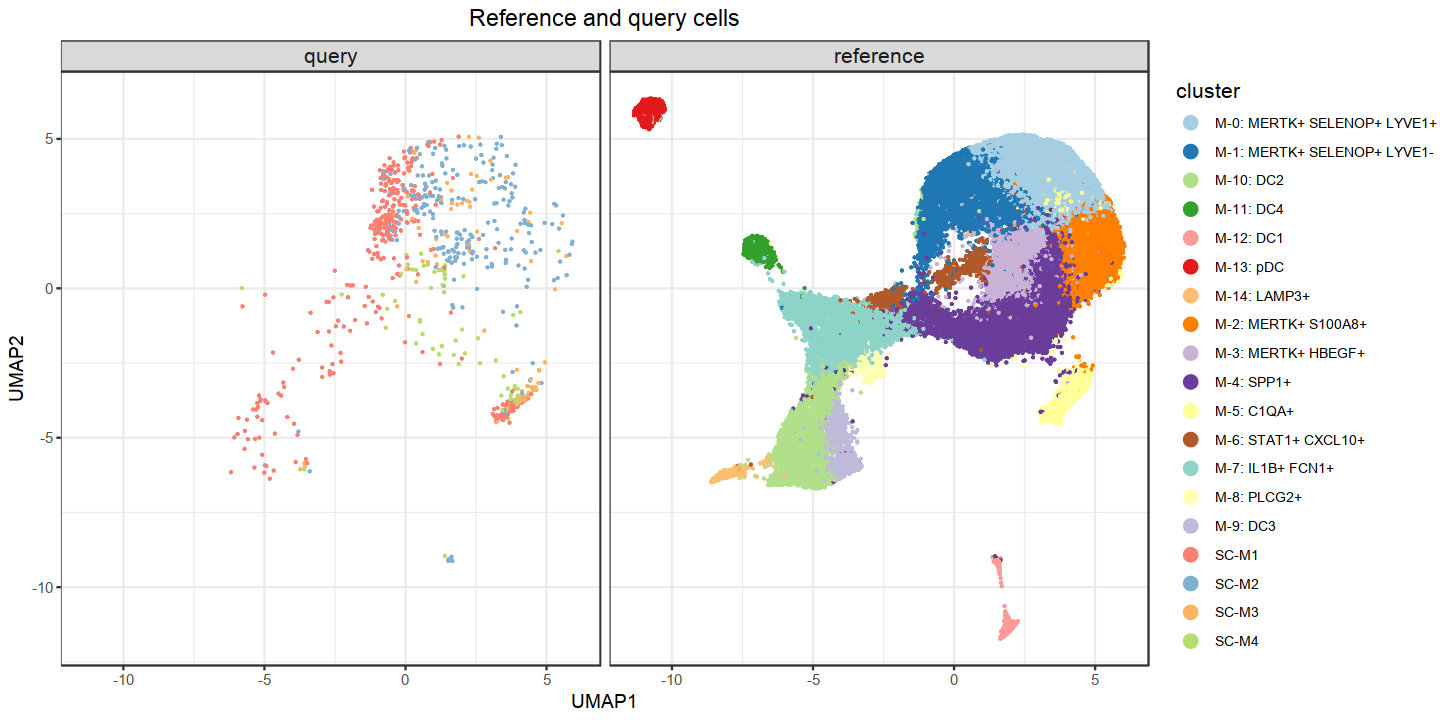

In [58]:
options(repr.plot.height = 6, repr.plot.width = 12)
colors = c( RColorBrewer::brewer.pal(12,'Paired'), 
           RColorBrewer::brewer.pal(12,'Set3'), 
           RColorBrewer::brewer.pal(9,'Set1'))
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cluster', facet.by = 'ref_query', size = 1) + scale_color_manual(values = colors)

In [59]:
table(queryM$meta_data$M_pred_knn_5, queryM$meta_data$cluster)

                             
                              SC-M1 SC-M2 SC-M3 SC-M4
  M-0: MERTK+ SELENOP+ LYVE1+    14    75    19     0
  M-1: MERTK+ SELENOP+ LYVE1-   144    52    10     0
  M-2: MERTK+ S100A8+             1    35     7     2
  M-3: MERTK+ HBEGF+              4    18     4     4
  M-4: SPP1+                      9    25     1    13
  M-5: C1QA+                     65    23    42    26
  M-6: STAT1+ CXCL10+            21     1     8    20
  M-7: IL1B+ FCN1+               26     0     0     2
  M-8: PLCG2+                    17     0     0     1
  M-9: DC3                        1     0     0     0
  M-10: DC2                      43     1     2     0
  M-11: DC4                       0     0     0     1
  M-12: DC1                       1     7     0     1
  M-13: pDC                       2     0     0     1
  M-14: LAMP3+                    1     0     0     0

In [60]:
saveRDS(queryM, 'Query_Objects/query_M.rds')

### Log(OR)
Plot the log odds-ratio

In [61]:
t = table(queryM$meta_data$M_pred_knn_5, queryM$meta_data$cluster)
tpseudo = t %>% Matrix() + 0.5 # Add pseudocount
or = tpseudo # initialize results (same dimensions as t)
for (i in 1:ncol(tpseudo)) { # for each phase 1 cluster
    for (j in 1:nrow(t)) { # for each phase 2 cluster 
        a = tpseudo[j, i]
        b = sum(tpseudo[j, -i])
        c = sum(tpseudo[-j, i])
        d = sum(tpseudo[-j, -i])
        
        or[j, i] = (a/b) / (c/d)
    }
}
round(log(or), 3)

15 x 4 Matrix of class "dgeMatrix"
                             
                               SC-M1  SC-M2  SC-M3  SC-M4
  M-0: MERTK+ SELENOP+ LYVE1+ -1.927  1.870  0.449 -3.362
  M-1: MERTK+ SELENOP+ LYVE1-  1.352 -0.403 -1.256 -4.182
  M-2: MERTK+ S100A8+         -3.349  2.046  0.267 -0.722
  M-3: MERTK+ HBEGF+          -1.692  1.152  0.106  0.399
  M-4: SPP1+                  -1.351  0.887 -1.624  1.331
  M-5: C1QA+                  -0.216 -1.149  1.275  0.793
  M-6: STAT1+ CXCL10+         -0.190 -2.825  0.301  2.017
  M-7: IL1B+ FCN1+             2.266 -3.348 -2.206 -0.215
  M-8: PLCG2+                  2.163 -2.915 -1.776 -0.330
  M-9: DC3                     0.173 -0.828  0.303  0.584
  M-10: DC2                    2.560 -2.735 -1.034 -2.427
  M-11: DC4                   -1.442 -0.828  0.303  2.207
  M-12: DC1                   -1.692  1.571 -1.144  0.350
  M-13: pDC                    0.173 -1.420 -0.288  1.357
  M-14: LAMP3+                 0.173 -0.828  0.303  0.584

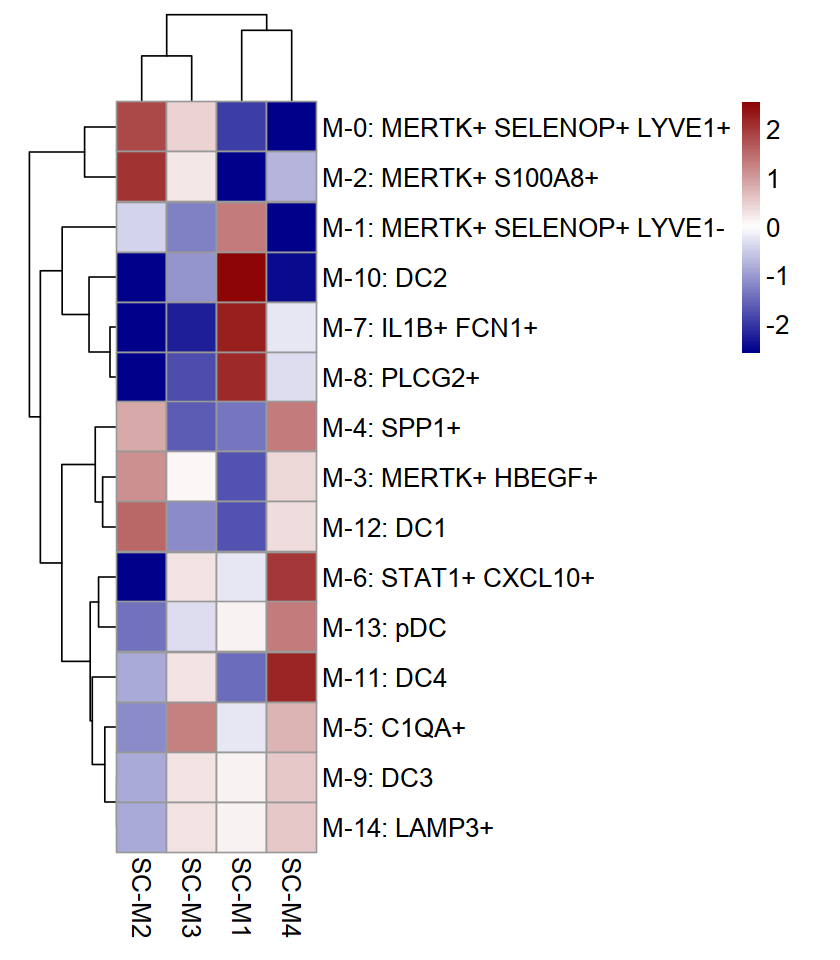

In [62]:
options(repr.plot.height = 8, repr.plot.width = 7)
range <- max(log(or))
pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
        fontsize = 15, cellheight = 30, cellwidth = 30)

# Save to figures
pheatmap(log(or), breaks = seq(-range, range, length.out = 100), 
         color = colorRampPalette(c("darkblue", "white", "darkred"))(100),
        fontsize = 15, cellheight = 30, cellwidth = 30, filename = 'figures/M_heatmap.pdf')

## All done!

In [63]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] rtracklayer_1.50.0   GenomicRanges_1.42.0 GenomeInfoDb_1.26.7 
 [4] IRanges_2.24.1       S4Vectors_0.28.1     BiocGenerics_0.36.1 
 [7] glue_1.4.2           furrr_0.2.2          future_1.21.0       
[10] data.table_1.14.0    uwot_0.1.10 